# Molecule Alpha Simulations

Repository: https://gitlab.com/linumlabs/molecule-system-modelling

**What do we want to investigate given certain assumptions?**

1. Assuming a buy & hold investment behaviour, what tax rate results in reasonable investor break-even period and reaching the funding goal.
2. Given a certain tax rate, what user base and behaviour is needed to reach funding goal in given period.
3. How can we design the bonding curve such that the funding goal is reached within the given time allocated?
4. How can we design the tax such that investors are rewarded fairly, both early and late?
5. How can we fairly dissolve a project and redistribute its collateral when completed?

**In an ideal efficient market, we hope to:**

1. Reach the funding goal in the given period
2. Reward investors fairly
3. Promote further investment

**Funding outcomes can be any of the following, with certain consequences:**

Market creators
1. Funding reached within time period
2. Funding reached before time period
3. Funding not reached

Investors
1. Investors reach ROI
2. Investors make a profit
3. Investors make a loss

**Given the funding goal and period, what parameters will help us reach that goal?**

1. Tax rate
2. Total investment
3. Investor activity
4. Bonding curve

# Learnings

## Number 1
The variance or sensitivity to a parameter can often tell you a lot more than the raw result of an experiment.
This is especially true in a black-box system or a system where there is large uncertainty surrounding the exogenous inputs or collective behaviour of actors in the system.

## Module imports

In [157]:
import sys
sys.path.append("../lib/python3.7/site-packages")

import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline
import math
from scipy.optimize import fsolve
import scipy.integrate as integrate
from datetime import timedelta

from decimal import Decimal
import numpy as np
import pandas as pd
from pynverse import inversefunc

import ipywidgets as widgets
from IPython.display import display

from abc import ABC, abstractmethod
from enum import Enum, auto
from functools import partial
import random
import uuid
import json

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='BenjaminScholtz', api_key='8HheLHWEyoXDuLOiQ4ZO')

from helpers import *

## Parameters

In [58]:
params = {
    'tax_rate': [.05, .10], # percentage
}

initial_conditions = {
    'investors': [100], # total for funding round
    'trading_balance': [10_000], # dollars
}

projects = 1
max_investors_per_project = 20
investment_size = 1000.0

default_gradient = 1/17_500.0
default_shift = 0.5

sigmoid_inflection = 80
sigmoid_slope = 1/20

blocks_per_year = 2102400
blocks_per_month = blocks_per_year/12
blocks_per_day = blocks_per_year/365

time_steps = int(12*30) # approx. 30 days per month

time_steps

360

## Business Logic

In [59]:
# monotonically increasing polynomial function
def bonding_function(x, m=default_gradient, c=default_shift):
    return np.multiply(m, x) + c
#     C = 10
#     a = 0.001
#     return C * (1 - np.exp(-a*x)) + 1
# y = np.tanh(x/(token_supply*.5))

def tax_function(x, m=default_gradient, c=default_shift):
    return np.multiply(m, x) + c*(1 - params['tax_rate'][0])
#     C = 10
#     a = 0.001
#     return C * (1 - np.exp(-a*x))

# this is essentially numerical integration
#     return [np.sum(bonding_function(x[:index])) for index,_ in enumerate(x)]

def integral_function(x):
    return integrate.quad(lambda i: bonding_function(i), 0, x)[0]

# invariant function
def collateral_pool(x):
    return [integral_function(x[index]) for index,_ in enumerate(x)]
    
def inverse_integral_function(x):
    func = inversefunc(integral_function)
    return func(x)

def final_collateral(x):
    return integrate.quad(lambda i: bonding_function(i), x[0], x[-1])

def vault_pool(x):
    return np.subtract(collateral_pool(x), [integrate.quad(lambda i: tax_function(i), x[0], x[index])[0] for index,_ in enumerate(x)])

def investor_pool(x):
    return np.subtract(collateral_pool(x), vault_pool(x))

# Contract functions

def price_to_mint(x_T, total_supply, pool_balance, gradient):
    return integral_function(total_supply + x_T) - pool_balance

def reward_for_burn(x_T, total_supply, pool_balance):
    return pool_balance - integral_function(total_supply - x_T)

def collateral_to_token_buying(x_D, total_supply):
    return inverse_integral_function(integral_function(total_supply) + x_D) - total_supply

def collateral_to_token_selling(x_D, total_supply):
    try:
        return total_supply - inverse_integral_function(integral_function(total_supply) - x_D)
    except ValueError:
        return 0

In [156]:
# Test integral and inverse integral
a = 50
b = integral_function(a)
c = inverse_integral_function(b)
assert(math.floor(a) == math.floor(c))
c

array(50.00000003)

In [62]:
x = np.linspace(0,10_000,10_00)

y = bonding_function(x)
t = tax_function(x)
c = collateral_pool(x)
v = vault_pool(x)
i = investor_pool(x)

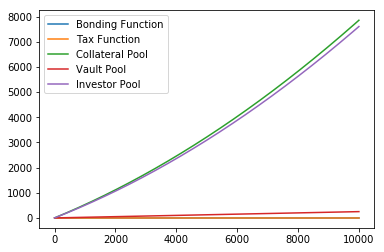

In [63]:
plt.plot(x, y, label='Bonding Function')
plt.plot(x, t, label='Tax Function')
plt.plot(x, c, label='Collateral Pool')
plt.plot(x, v, label='Vault Pool')
plt.plot(x, i, label='Investor Pool')
plt.legend(loc='upper left')
plt.show()

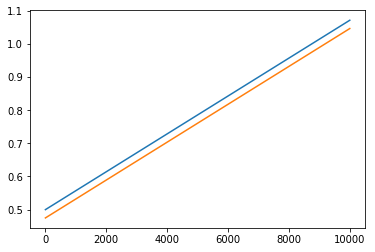

In [64]:
# Bonding function and tax (sell) function
plt.plot(x, y, x, t)
plt.show()

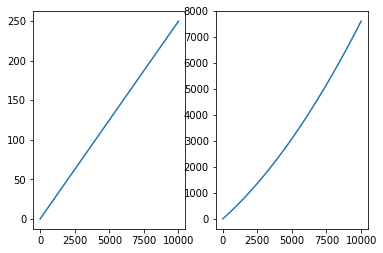

In [65]:
# Vault and investor pool
fig, axs = plt.subplots(1,2)

axs[0].plot(x, v)
axs[1].plot(x, i)

## States

### Configure graph

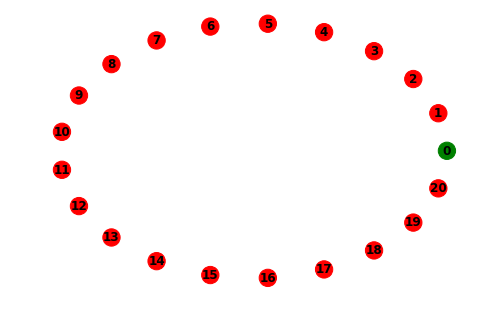

In [69]:
# class Vault:
#     def __init__(self):
#         self.reserve = 0
        
# class BondingCurve:
#     def __init__(self):
#         self.bonded_tokens = 0
#         self.reserve = 0

# class Project:
#     def __init__(self):
#         self.vault = Vault()
#         self.bonding_curve = BondingCurve()
#         self.funding_goal = 1_000_000
#         self.funding_period = 6 # months
#         self.tax_rate = .05
    
# class Investor:
#     def __init__(self):
#         self.trading_balance = 10_000 # dollars
#         self.invested = 0
#         self.bonded_tokens = 0
#         self.estimated_value = 0 # dollar value of tokens
#         self.sentiment = 1 # 1 being hold indefinitely, 0 being sell immediately... tbd

network = nx.Graph()
color_map = []

for index in range(projects):
    color_map.append('green')
    
    network.add_node(index, _type='project')
    network.nodes[index]['vault'] = {
        'reserve': 0
    }
    network.nodes[index]['bonding_curve'] = {
        'bonded_tokens': 0,
        'reserve': 0
    }
    network.nodes[index]['funding_goal'] = 1_000_000
    network.nodes[index]['funding_period'] = 6
    network.nodes[index]['tax_rate'] = .05
    
for index in range(max_investors_per_project):
    color_map.append('red')
    index = index + projects
    
    network.add_node(index, _type='investor')
    network.nodes[index]['trading_balance'] = 10_000
    network.nodes[index]['invested'] = 0
    network.nodes[index]['bonded_tokens'] = 0
    network.nodes[index]['estimated_value'] = 0
    network.nodes[index]['sentiment'] = 0
    network.nodes[index]['desired_roi'] = .1 # If sentiment < 1, when estimated_value is greater than invested by more than desired ROI, then sell

nx.draw_kamada_kawai(network, node_color=color_map, font_weight='bold', with_labels=True) # with_labels=True

class NetworkState(StateType):
    network = auto()
    
    @classmethod
    def initial_conditions(cls):
        return {
            cls.network: network,
        }

In [70]:
class StateAgregated(StateType):
    pool_balance = auto()
    
    @classmethod
    def initial_conditions(cls):
        return {
            **cls.initial_state()
        }

## Actions

In [154]:
class ActionsExogenous(ActionsType):
    new_investors = auto()
    investment_pool_generator = auto()
    
    @classmethod
    def _new_investors(cls, params, step, sL, s, _input):        
        network: nx.Graph = s[NetworkState.network]

        projects = get_node_ids_of_type(network, 'project')
        project = projects[0]
        investors = get_node_ids_of_type(network, 'investor')

        currently_invested = list(network.neighbors(project))
        
        number_of_investors = max_investors_per_project/(1 + math.pow(math.e, -(s['timestep'] - sigmoid_inflection)*sigmoid_slope))
        number_of_investors = max(math.floor(number_of_investors), 0)

        new_investors = investors[len(currently_invested) : number_of_investors]

        for index in new_investors:
            network.add_edge(project, index)
        
        return (NetworkState.network, network)
    
    @classmethod
    def _investment_pool_generator(cls, params, step, sL, s, _input):
        y = StateExogenous.tx_volume
        x = s[StateExogenous.tx_volume]*(1+2*eta*np.random.rand()*(1-s[StateExogenous.tx_volume]/tampw))
        return (y, x)

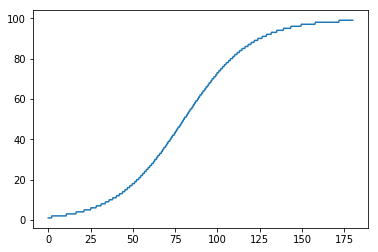

In [153]:
max_user_base = 100

sigmoid_inflection = 80
sigmoid_slope = 1/20

x = np.linspace(0, 180, 500)
y = np.divide(max_user_base, (1 + np.power(np.e, -np.multiply(np.subtract(x, sigmoid_inflection), sigmoid_slope))))
y = np.floor(y)
y[y < 0] = 0

plt.plot(x, y)
plt.show()

In [130]:
class TradingActions(ActionsType):
    perform_trades = auto()
    
    @classmethod
    def _perform_trades(cls, params, step, sL, s, _input):
        network: nx.Graph = s[NetworkState.network]

        projects = get_node_ids_of_type(network, 'project')
        project = projects[0]
        investors = get_node_ids_of_type(network, 'investor')
        
        currently_invested = list(network.neighbors(project))
        
        for index in currently_invested:
            project = projects[0]
            
            project_node = network.node[project]
            investor_node = network.node[index]
            
            vault = project_node['vault']
            bonding_curve = project_node['bonding_curve']
            
            # Calculate buy tax
            collateral_to_invest = investment_size
            collateral_tax = collateral_to_invest * project_node['tax_rate']
            collateral_less_tax = collateral_to_invest - collateral_tax
            
            estimated_value = reward_for_burn(investor_node['bonded_tokens'], bonding_curve['bonded_tokens'], bonding_curve['reserve'])
            check_funds = investor_node['trading_balance'] >= collateral_to_invest
            check_initial_investment = investor_node['invested'] > 0
            check_roi = investor_node['invested'] > 0 and (estimated_value - investor_node['invested']) / investor_node['invested'] > investor_node['desired_roi']/2
            
            if not check_initial_investment: #check_funds and (not check_initial_investment or check_roi):
                tokens_buy = collateral_to_token_buying(collateral_less_tax, bonding_curve['bonded_tokens'])

                bonding_curve['bonded_tokens'] += tokens_buy
                bonding_curve['reserve'] += collateral_less_tax

                vault['reserve'] += collateral_tax

                investor_node['trading_balance'] -= collateral_to_invest
                investor_node['invested'] += collateral_to_invest
                investor_node['bonded_tokens'] += tokens_buy
            
            estimated_value = reward_for_burn(investor_node['bonded_tokens'], bonding_curve['bonded_tokens'], bonding_curve['reserve'])
            check_sentiment = investor_node['sentiment'] < 1
            check_roi = investor_node['invested'] > 0 and (estimated_value - investor_node['invested']) / investor_node['invested'] > investor_node['desired_roi']
            
            # When estimated_value is greater than invested by more than desired ROI, then sell
            if check_sentiment and check_roi:
                # Sell 100% of holdings
                sell_holdings(investor_node, bonding_curve, estimated_value)
            
        return (NetworkState.network, network)
    
class UpdateActions(ActionsType):
    update_balances = auto()
    
    @classmethod
    def _update_balances(cls, params, step, sL, s, _input):
        network: nx.Graph = s[NetworkState.network]

        projects = get_node_ids_of_type(network, 'project')
        project = projects[0]
        investors = get_node_ids_of_type(network, 'investor')
        
        currently_invested = list(network.neighbors(project))
        
        for index in currently_invested:
            project = projects[0]
            
            project_node = network.node[project]
            investor_node = network.node[index]
            
            vault = project_node['vault']
            bonding_curve = project_node['bonding_curve']
    
            investor_node['estimated_value'] = reward_for_burn(investor_node['bonded_tokens'], bonding_curve['bonded_tokens'], bonding_curve['reserve'])
        
        return (NetworkState.network, network)
    
class MetricActions(ActionsType):
    agregate = auto()
    pool_balance = auto()
    
    @classmethod
    def _pool_balance(cls, params, step, sL, s, _input):
        y = StateAgregated.pool_balance
        if _input[cls.agregate] == 1:
            x = s[State.community_state].pool_balance
        else:
            x = s[StateAgregated.pool_balance]
        return (y, x)

## Actions

In [131]:
class MetricPolicies(PoliciesType):
    def agregate(self, params, step, sL, s):
        return({MetricActions.agregate: 1})
    
class Policies(PoliciesType):
    #def __init__(self):
        
    def update_balances(self, params, step, sL, s):
        return({UpdateActions.update_community_state: True})

## cadCAD Model Initialization

In [132]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
from cadCAD.configuration.utils import config_sim

simulation_parameters = config_sim({
    'T': range(time_steps),
    'N': 1,
    'M': params
})
simulation_parameters

[{'N': 1, 'T': range(0, 360), 'M': {'tax_rate': 0.05, 'max_holdings': 100000}},
 {'N': 1, 'T': range(0, 360), 'M': {'tax_rate': 0.1, 'max_holdings': 100000}}]

In [133]:
# %%capture

ts_format = '%Y-%m-%d %H:%M:%S'
t_delta = timedelta(days=30, minutes=0, seconds=0)
def time_model(_g, step, sL, s, _input):
    y = 'time'
    x = ep_time_step(s, dt_str=s['time'], fromat_str=ts_format, _timedelta=t_delta)
    return (y, x)

exogenous_states = {
#     'time': time_model
}
env_processes = {}

initial_state = {
    **NetworkState.initial_conditions(),
#     **StateExogenous.initial_conditions(),
#     **StateAgregated.initial_conditions()
}

metric_policies = MetricPolicies()
policies = Policies()

partial_state_update_blocks = [
    # Exogenous inputs
    {
        'policies': {},
        'variables': {
            NetworkState.network: ActionsExogenous.new_investors.method,
        }
    },
    {
        'policies': {},
        'variables': {
            NetworkState.network: TradingActions.perform_trades.method,
        }
    },
    {
        'policies': {},
        'variables': {
            NetworkState.network: UpdateActions.update_balances.method,
        }
    }
]

## Model Simulation

In [134]:
from cadCAD.configuration import append_configs

append_configs(
    initial_state=initial_state, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters, #dict containing simulation parameters
#     raw_exogenous_states=exogenous_states,
#     env_processes=env_processes
)

In [135]:
# from cadCAD.configuration import Configuration
from cadCAD import configs
import cadCadFunctions as c2F
from tabulate import tabulate

# config = Configuration(initial_state=initial_state, #dict containing variable names and initial values
#                        partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
#                        sim_config=simulation_parameters, #dict containing simulation parameters
#                        raw_exogenous_states=exogenous_states,
#                        env_processes=env_processes,
#                       )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(context=exec_mode.single_proc)
run = Executor(exec_context=exec_context, configs=configs) # Pass the configuration object inside an array
raw_result, tensor = run.execute() # The `main()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
from matplotlib import cm
import pandas as pd

single_proc: [<cadCAD.configuration.Configuration object at 0x7f72a491def0>, <cadCAD.configuration.Configuration object at 0x7f72a491dd68>, <cadCAD.configuration.Configuration object at 0x7f726e667240>, <cadCAD.configuration.Configuration object at 0x7f726e667d68>, <cadCAD.configuration.Configuration object at 0x7f728034f5c0>, <cadCAD.configuration.Configuration object at 0x7f728034fb00>, <cadCAD.configuration.Configuration object at 0x7f72a04ac5c0>, <cadCAD.configuration.Configuration object at 0x7f72a04ac470>, <cadCAD.configuration.Configuration object at 0x7f726e7b12e8>, <cadCAD.configuration.Configuration object at 0x7f726e7b1780>, <cadCAD.configuration.Configuration object at 0x7f72a06674a8>, <cadCAD.configuration.Configuration object at 0x7f726e1f5c50>, <cadCAD.configuration.Configuration object at 0x7f72a0167080>, <cadCAD.configuration.Configuration object at 0x7f72a0167dd8>, <cadCAD.configuration.Configuration object at 0x7f7280c15dd8>, <cadCAD.configuration.Configuration objec

In [137]:
# sys.setrecursionlimit(5000)

# i = 0
# verbose = False
# results = {}
# for raw_result, tensor_field in run.execute():
#     result = pd.DataFrame(raw_result)
#     if verbose:
#         print()
#         print(f"Tensor Field: {type(tensor_field)}")
#         print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
#         print(f"Output: {type(result)}")
#         print(tabulate(result, headers='keys', tablefmt='psql'))
#         print()
#     results[i] = {}
#     results[i]['result'] = result
#     results[i]['simulation_parameters'] = simulation_parameters[i]
#     i += 1

# results[0]['result']

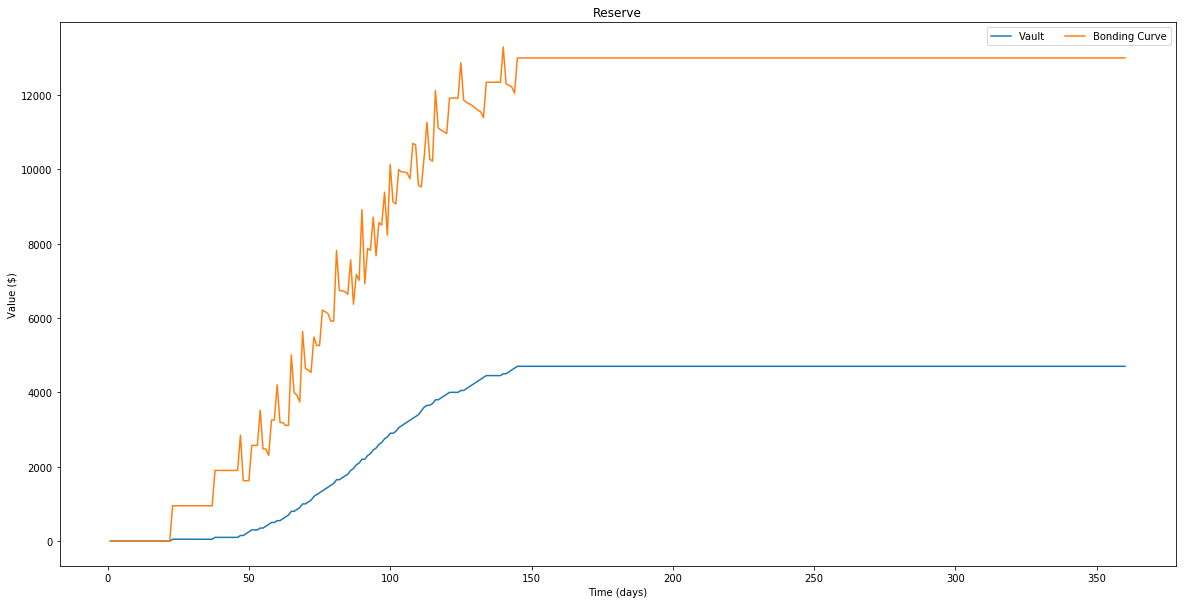

In [139]:
df = pd.DataFrame(raw_result)
rdf = df[df.substep==3].copy()

rdf['vault_reserve'] = rdf[NetworkState.network].apply(lambda g: np.array([g.node[j]['vault']['reserve'] for j in get_node_ids_of_type(g, 'project')]))
rdf['bonding_curve_reserve'] = rdf[NetworkState.network].apply(lambda g: np.array([g.node[j]['bonding_curve']['reserve'] for j in get_node_ids_of_type(g, 'project')]))

# df['conviction'] = df.network.apply(lambda g: np.array([g.nodes[j]['conviction'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
# df['candidate_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))

plt.figure(1,figsize=(20,10)) 
plt.plot(rdf.timestep, rdf['vault_reserve'])
plt.plot(rdf.timestep, rdf['bonding_curve_reserve'])
plt.title('Reserve')
plt.ylabel('Value ($)')
plt.xlabel('Time (days)')
plt.legend(['Vault', 'Bonding Curve'], ncol = 2)

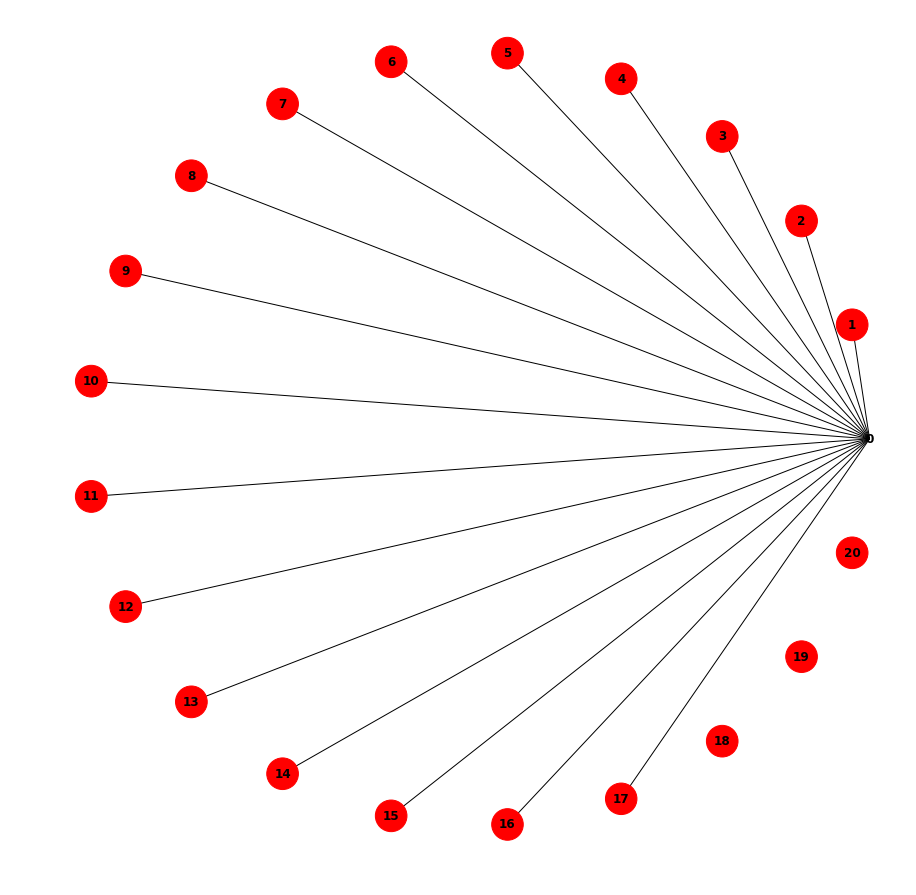

In [150]:
def investor_balance(g):
    projects = get_node_ids_of_type(network, 'project')
    project = projects[0]
    
    project_node = network.node[project]
    vault = project_node['vault']
    bonding_curve = project_node['bonding_curve']

    result = []
    for j in get_node_ids_of_type(g, 'investor'):
        balance = g.node[j]['estimated_value'] + g.node[j]['trading_balance']
        result.append(balance)       
    return result

rdf['investor_balance'] = rdf[NetworkState.network].apply(lambda g: investor_balance(g))

node_sizes = np.append([0], np.divide(rdf['investor_balance'][time_steps], 10))
plt.figure(1,figsize=(12,12)) 
nx.draw_circular(df[NetworkState.network][360], node_color=color_map, node_size=node_sizes, font_weight='bold', with_labels=True) # with_labels=True

# print(type(df[NetworkState.network]))
# df = pd.DataFrame(raw_result)
# print(df[NetworkState.network].apply(lambda g: g.nodes))

In [151]:
rdf.head(10).append(rdf.tail(10))

,NetworkState.network,run,substep,timestep,vault_reserve,bonding_curve_reserve,investor_balance,padded_investor_balance
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,3,1,[0],[0],"[10000, 10000, 10000, 10000, 10000, 10000, 100...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,3,2,[0],[0],"[10000, 10000, 10000, 10000, 10000, 10000, 100...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,3,3,[0],[0],"[10000, 10000, 10000, 10000, 10000, 10000, 100...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,3,4,[0],[0],"[10000, 10000, 10000, 10000, 10000, 10000, 100...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,3,5,[0],[0],"[10000, 10000, 10000, 10000, 10000, 10000, 100...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,3,6,[0],[0],"[10000, 10000, 10000, 10000, 10000, 10000, 100...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,3,7,[0],[0],"[10000, 10000, 10000, 10000, 10000, 10000, 100...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
24,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,3,8,[0],[0],"[10000, 10000, 10000, 10000, 10000, 10000, 100...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,3,9,[0],[0],"[10000, 10000, 10000, 10000, 10000, 10000, 100...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
30,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,3,10,[0],[0],"[10000, 10000, 10000, 10000, 10000, 10000, 100...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Text(0, 0.5, 'share of estimated valuation')

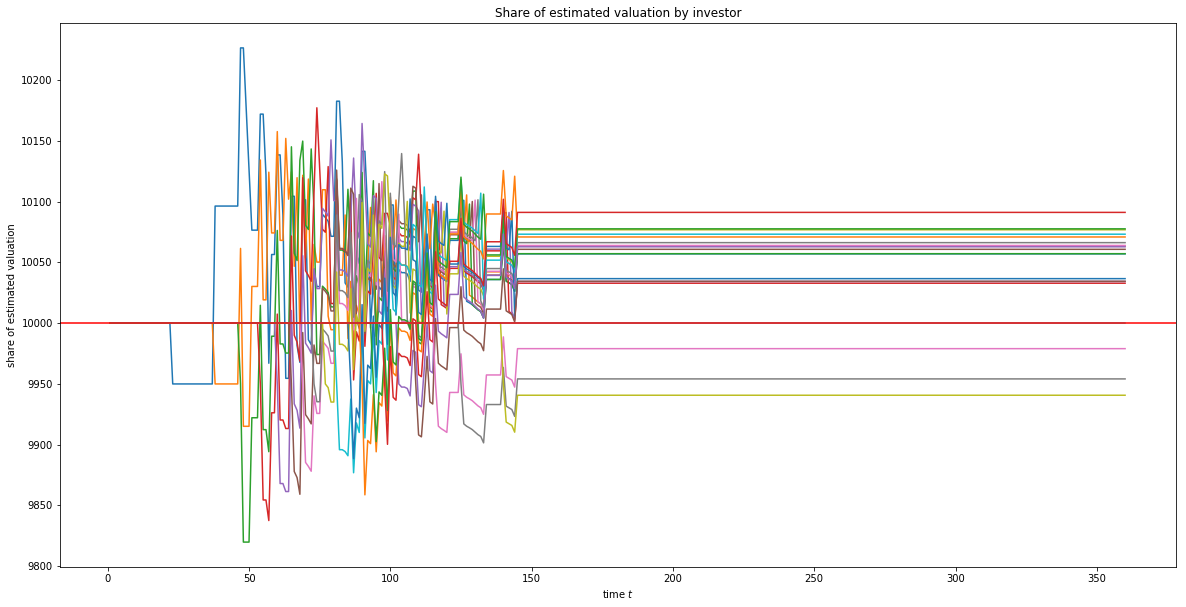

In [152]:
plt.figure(1,figsize=(20,10)) 
plt.plot(rdf.timestep, make2D('investor_balance', rdf))
plt.axhline(y=10_000, color='r', linestyle='-')
plt.title('Share of estimated valuation by investor')
plt.xlabel('time $t$')
plt.ylabel('share of estimated valuation')

# Continuous Taxation

Tax rate set at a percentage per time period. For example 5% per month. See below re. block time.

* Investigate harburger tax

From the Compound interest rate model:

See https://github.com/compound-finance/compound-money-market/blob/master/contracts/InterestRateModel.sol & https://github.com/compound-finance/compound-money-market

```    /**
      * @notice Gets the current supply interest rate based on the given asset, total cash and total borrows
      * @dev The return value should be scaled by 1e18, thus a return value of
      *      `(true, 1000000000000)` implies an interest rate of 0.000001 or 0.0001% *per block*.
      * @param asset The asset to get the interest rate of
      * @param cash The total cash of the asset in the market
      * @param borrows The total borrows of the asset in the market
      * @return Success or failure and the supply interest rate per block scaled by 10e18
*/
```

They use an interest rate based on `uint constant blocksPerYear = 2102400;`

Probably the best explanation of continuous tokens: https://yos.io/2018/11/10/bonding-curves/

First proposal:

1. Use a continuous token model, with a negative exponential function
2. A negative exponential function should dampen the effect seen in Protea where early investors are unfairly rewarded
3. When it comes time to dissolve the market, the connector weight can be set to 100% - essentially making all tokens the same price, and making the market entirely collateralized
4. A tax can be calculated as a function of block time, collateral pool size, funding goal, and funding period - optimized to reach a funding goal in the given period, no matter what

Assumptions:

1. You want to tax early investors less than late investors - this coincides with having a progressive tax
2. Using a continuous token model you could continuously decollateralize the market more easily

Tax rate should vary between r_min and r_max. An ideal curve for this would be a generalized logistic function with A = -1, let's call it G()
https://en.wikipedia.org/wiki/Generalised_logistic_function

G() where r_min is at the origin and r_max at the assymptote.

When the connector weight is 100%, all investors are taxed equally...? When the connector weight is any less than 100%, early investors are effectively taxed less.
When there is less activity, ideally the tax rate should be lower, to incetivize new investors. If the tax rate is based on the collateral pool size, we need to be careful not to make the funding goal a never reachable assymptote. Given a certain market size, let's calculate the continuous tax rate such that the funding goal is reached in at least the given period.

# Investor Story

At this stage, with a limited understanding of the investment behaviour of our target market, and even the size - we're better off simulting the user base as a monotonically increasing curve that approaches a reasonable assymptote. We can decide what the best and worst case scenarios are and simulate these - this will be what the asymptotic total investment value is, and how long it take to reach it.

We can theorize that given 100 investors, with a fund of 100_000 each to invest, we could end up with a total investment pool of 10_000_000 within an ideal period of 6 months. Worst case we only reach 20% of our invesor market, or 20% of the theoretical total investment pool, and we end up with 2_000_000. We can adjust how we simulate this or what the best and worse case scenarios are, but basically we should create an investor story and work from that, rather than digging into investor behaviour too deeply.